In [1]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path):
   return glob.glob(path)

In [2]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [3]:
# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [4]:
print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Vietnamese', 'French', 'Portuguese', 'Russian', 'Polish', 'Dutch', 'Czech', 'Italian', 'Arabic', 'Scottish', 'Irish', 'German', 'Greek', 'English', 'Spanish', 'Korean', 'Chinese', 'Japanese']
O'Neal


In [0]:
import torch

In [0]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [0]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        #category = [1, n_categories]
        #input = [1, n_letters]
        #hidden = [1, hidden_size]

        input_combined = torch.cat((category, input, hidden), 1)

        #input_combined = [1, n_categories+ n_letters + hidden_size]

        hidden = self.i2h(input_combined)

        #hidden = [1, hidden_size]

        output = self.i2o(input_combined)

        #output = [1, output_size]

        output_combined = torch.cat((hidden, output), 1)

        #output_combined = [1, hidden_size + output_size]

        output = self.o2o(output_combined)

        #output = [1, output_size]

        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
model = RNN(n_letters, 512, n_letters)


In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 370,638 trainable parameters


In [0]:
criterion = nn.NLLLoss()


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [0]:
model=model.to(device)
criterion=criterion.to(device)

In [0]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor.to(device), input_line_tensor.to(device), target_line_tensor.to(device)

In [0]:

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()
    hidden = hidden.to(device)

    model.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)


In [0]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 36s (5000 5%) 2.7790
1m 11s (10000 10%) 2.7435
1m 46s (15000 15%) 2.3354
2m 22s (20000 20%) 2.7419
2m 57s (25000 25%) 3.0291
3m 32s (30000 30%) 2.7915
4m 7s (35000 35%) 2.5828
4m 42s (40000 40%) 2.7244
5m 17s (45000 45%) 2.3808
5m 52s (50000 50%) 2.5245
6m 28s (55000 55%) 2.6907
7m 3s (60000 60%) 3.0445
7m 38s (65000 65%) 2.4734
8m 14s (70000 70%) 3.1509
8m 49s (75000 75%) 2.3023
9m 25s (80000 80%) 2.5233
10m 1s (85000 85%) 2.6283
10m 37s (90000 90%) 1.7882
11m 12s (95000 95%) 1.4711
11m 47s (100000 100%) 1.7843


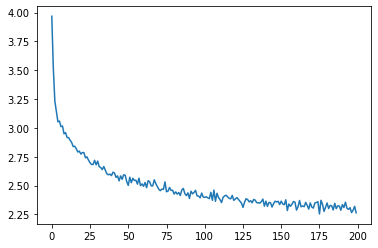

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [0]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = model.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = model(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Roskan
Uarichovove
Salovak
Gares
Ering
Rour
Salla
Pare
Allan
Chan
Han
Iun


In [0]:
samples('French,'T')

Tare
